Setup

In [15]:
import os
import csv
import numpy as np
from scipy.stats import zscore
from scipy.signal import welch
from scipy.fft import fft, fftfreq
import librosa
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score

# in theory, this should automagically detect whether or not you're in colab and set the directory accordingly
# if in colab, put link to shared 378final folder in My Drive
# if local, make a dataset folder containing the .wav folders in the same directory as the .py file
# we won't track dataset folder on Git because it's 2GB Lol.
try:
    from google.colab import drive
    drive.mount("/content/drive")
    dataset_directory = "/content/drive/My Drive/378final/dataset"
except:
    dataset_directory = "./dataset"

# Hardcoded labels
labels = ["Angry", "Disgusted", "Fearful", "Happy", "Neutral", "Sad", "Suprised"]
# Numpy array makes it easier to make a list from a list of indices
labels = np.array(labels)


Data Exploration

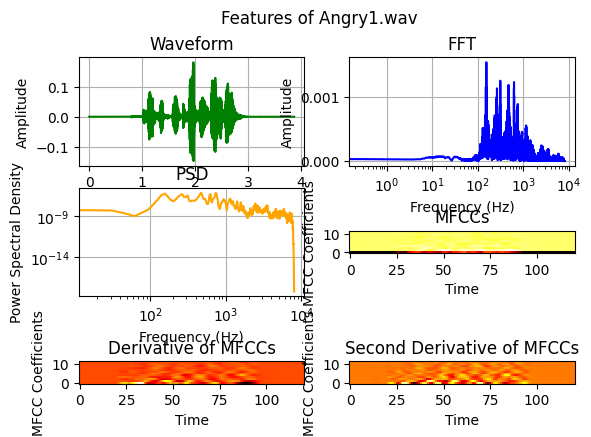

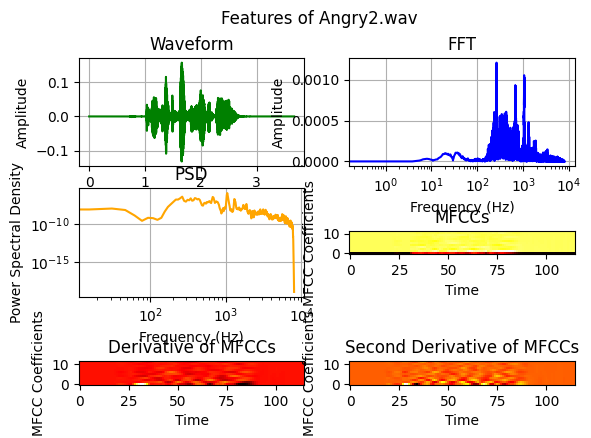

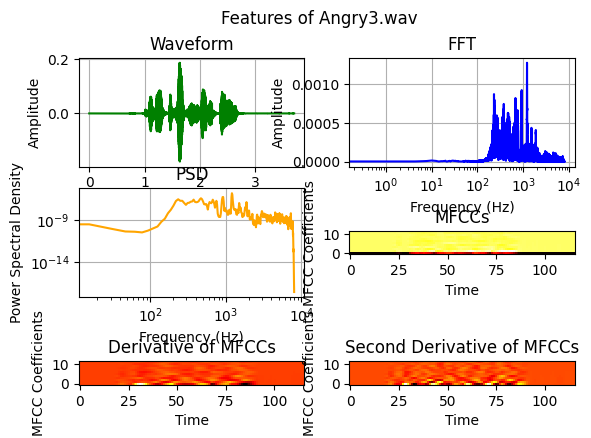

In [8]:
"""Data Exploration"""

# we would like to get a sense of the signal's properties so see what are some good features to extract
#j = 1
#for emotion in labels:
emotion = "Angry"
for j in range(1, 4):
    file_path = f"{dataset_directory}/{emotion}/{emotion}{j}.wav"
    audio, sampling_rate = librosa.load(file_path, sr=16000)  # load full audio signal

    fig,axs = plt.subplots(3,2)

    # raw audio waveform
    axs[0,0].plot([i/sampling_rate for i in range(audio.shape[0])], audio, color = "green")
    axs[0,0].set_title("Waveform")
    axs[0,0].set_xlabel("Time (s)")
    axs[0,0].set_ylabel("Amplitude")
    axs[0,0].grid()

    # fft
    N = len(audio)
    yf = fft(audio)
    xf = fftfreq(N, 1 / sampling_rate)[:N // 2]
    axs[0,1].plot(xf, 2.0 / N * np.abs(yf[0:N // 2]), color = "blue")
    axs[0,1].set_title("FFT")
    axs[0,1].set_xlabel("Frequency (Hz)")
    axs[0,1].set_ylabel("Amplitude")
    axs[0,1].grid()
    axs[0,1].set_xscale("log")

    # psd
    f, Pxx = welch(audio, sampling_rate, nperseg=1024)
    axs[1,0].set_title("PSD")
    axs[1,0].set_xlabel("Frequency (Hz)")
    axs[1,0].set_ylabel("Power Spectral Density")
    axs[1,0].grid()
    axs[1,0].semilogy(f, Pxx, color = "orange")
    axs[1,0].set_xscale("log")

    # mfcc
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sampling_rate, n_mels=128) #can experiment with n_mels (try 22-128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mfccs = librosa.feature.mfcc(S=mel_spec_db, sr=sampling_rate, n_mfcc=12) #experiment with n_mfcc?? (8-20)

    delta_mfccs  = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)

    axs[1,1].imshow(mfccs, cmap="hot", interpolation="nearest", origin="lower")
    axs[1,1].set_title("MFCCs")
    axs[1,1].set_xlabel("Time")
    axs[1,1].set_ylabel("MFCC Coefficients")

    axs[2,0].imshow(delta_mfccs, cmap="hot", interpolation="nearest", origin="lower")
    axs[2,0].set_title("Derivative of MFCCs")
    axs[2,0].set_xlabel("Time")
    axs[2,0].set_ylabel("MFCC Coefficients")

    axs[2,1].imshow(delta2_mfccs, cmap="hot", interpolation="nearest", origin="lower")
    axs[2,1].set_title("Second Derivative of MFCCs")
    axs[2,1].set_xlabel("Time")
    axs[2,1].set_ylabel("MFCC Coefficients")

    # show all at once
    fig.suptitle(f"Features of {emotion}{j}.wav")
    plt.show()


Feature Extraction Function

In [16]:
"""Feature Extraction (per audio signal)"""
def extract_features(file_path, standard_audio_size=3):
    try:
        # Load the audio file
        # Apparently the sampling rate differs between files, so we fix it here
        audio, sampling_rate = librosa.load(file_path, sr=16000)

        # Pad/truncate to get standard length (so features are consistent length)
        padded_audio = librosa.util.fix_length(audio, size=standard_audio_size*sampling_rate)

        # Extract features
        mel_spec = librosa.feature.melspectrogram(y=padded_audio, sr=sampling_rate, n_mels=128, hop_length=1024, n_fft=4096)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mfccs = librosa.feature.mfcc(S=mel_spec_db, sr=sampling_rate, n_mfcc=12)
        delta_mfccs  = librosa.feature.delta(mfccs)
        delta2_mfccs = librosa.feature.delta(mfccs, order=2)

        all_features = np.vstack([mfccs, delta_mfccs, delta2_mfccs]).flatten(order='F')
        return all_features
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None


Extracting Train Data

In [17]:
"""Extracting Train Data"""
print("---Extracting Train Data---")

# Load dataset and extract features
training_samples = []
training_labels = []

for label in labels:
    print(f"Extracting: {label}")
    for num, file_name in enumerate(os.listdir(f"{dataset_directory}/{label}")):
        if (num < 500): # comment this out this to use ALL files
            file_path = f"{dataset_directory}/{label}/{file_name}"
            training_sample = extract_features(file_path)
            if training_sample is not None:
                training_samples.append(training_sample)
                training_labels.append(label)

# Convert to numpy arrays, encode labels
training_samples = np.array(training_samples)
training_labels = np.array(training_labels)
training_labels_encoded = [labels.tolist().index(label) for label in training_labels]
training_labels_encoded = np.array(training_labels_encoded)

# Scale features
scaler = StandardScaler()
training_samples_scaled = scaler.fit_transform(training_samples)


---Extracting Train Data---
Extracting: Angry
Extracting: Disgusted
Extracting: Fearful
Extracting: Happy
Extracting: Neutral
Extracting: Sad
Extracting: Suprised


Extracting Test Data

In [18]:
"""Extracting Test Data"""
print("---Extracting Test Data---")

# for status updates
num_test = len(os.listdir(f"{dataset_directory}/Test"))
checkpoints = []
for i in range(1, 5):
    checkpoints.append(round(i*num_test/4))

test_samples = []
test_nums = []
for i, file_name in enumerate(os.listdir(f"{dataset_directory}/Test")):
    for point in checkpoints:
        if i == point:
            print(f"{int(25*(checkpoints.index(point)+1))}% complete")
    file_path = f"{dataset_directory}/Test/{file_name}"
    test_sample = extract_features(file_path)
    if test_sample is not None:
        test_samples.append(test_sample)
        test_nums.append(int(file_name.split('.')[0]))

# Scale with same scaler as train data
test_samples = np.array(test_samples)
test_samples_scaled = scaler.transform(test_samples)


---Extracting Test Data---
25% complete
50% complete
75% complete


Training Model and Predicting (SVM w/ PCA)

In [ ]:
"""SVM w/ PCA"""
print("---Validating Model---")
# NOTE: It seems like the TAs wanted to reduce overfitting by using PCA. However, it also seems that, at least for the full dataset,
#       leaving higher variance in the data results in better validation scores!
#       And after some tests, turns out that not using PCA at all is slower, but nets a 20% accuracy bonus above 99% variance!

# SVM Model, preprocessing, and cross-validation initialization
svm_clf = SVC(kernel="rbf", C=1, gamma="auto")
pca = PCA(n_components=0.99) # preserve x% of variance in data
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
accuracies = []
do_PCA = False

# Perform cross-validation
for i, (train_index, val_index) in enumerate(kf.split(training_samples_scaled, training_labels_encoded)):
    print(f"Split #{i+1}")
    X_train, X_val = training_samples_scaled[train_index], training_samples_scaled[val_index]
    y_train, y_val = training_labels_encoded[train_index], training_labels_encoded[val_index]
    if do_PCA:
        PCA_X_train = pca.fit_transform(X_train)
        PCA_X_val = pca.transform(X_val)
    else:
        PCA_X_train = X_train
        PCA_X_val = X_val
    svm_clf.fit(PCA_X_train, y_train)
    y_pred = svm_clf.predict(PCA_X_val)
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy: {average_accuracy * 100:.2f}%")

print("---Training Final Model---")
# seems like more data requires higher variance
pca = PCA(n_components=0.99) # preserve x% of variance in data
if do_PCA:
    PCA_training_samples = pca.fit_transform(training_samples_scaled)
else:
    PCA_training_samples = training_samples_scaled
svm_clf.fit(PCA_training_samples, training_labels_encoded)



print("---Making Predictions---")

# Transform features using PCA
if do_PCA:
    PCA_test_samples = pca.transform(test_samples_scaled)
else:
    PCA_test_samples = test_samples_scaled

# Predict using the SVM (with decoded predictions)
PCA_test_pred = svm_clf.predict(PCA_test_samples)
PCA_test_pred_labels = labels[PCA_test_pred]
PCA_test_pred_labels_sorted = [test_label for _, test_label in sorted(zip(test_nums, PCA_test_pred_labels))]

# Save to a CSV for submission to Kaggle
with open("svm_PCA.csv", 'w', newline='', encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["filename", "emotion"])
    for i, emotion in enumerate(PCA_test_pred_labels_sorted):
        writer.writerow([f"{i+1}.wav", emotion])


---Validating Model---
Split #1
Split #2
Split #3
Split #4
Split #5
Average Accuracy: 52.59%
---Training Final Model---
---Making Predictions---


Training Model and Predicting (SVM w/ RFE)

In [ ]:
"""SVM w/ RFE"""

# sets whether or not to make a prediction after validation
# intuitively, you'd do this separately and use the entire training dataset, but
# i've seen that accuracy is highly dependent on number of samples
# so it's helpful to have the reassurance of a good model before submitting
PREDICT = True
LOG = False

N_FEATURES = 520
STEP_SIZE = 10
FIRST_STEP = 1100
RFE_TOL = 0.1
FINAL_TOL = 0.01



print("---Validating Model---")
# Checks validation accuracy at each step along the way
# Log name is <number of samples used to train - number of features to reduce to - step size(first step) - tolerance - zscore>.log
if LOG: logfile = open(f"./logs/{int(training_samples_scaled.shape[0]*0.8)}-{N_FEATURES}-{STEP_SIZE}({FIRST_STEP})-tol{RFE_TOL}.log", 'x')
print(f"Hyperparameters: {int(training_samples_scaled.shape[0]*0.8)} training samples, {N_FEATURES} sample features, step size {STEP_SIZE}, first step {FIRST_STEP}, tolerance {FINAL_TOL}")
if LOG: logfile.write(f"Hyperparameters: {int(training_samples_scaled.shape[0]*0.8)} training samples, {N_FEATURES} sample features, step size {STEP_SIZE}, first step {FIRST_STEP}, tolerance {FINAL_TOL}\n")

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(training_samples_scaled, training_labels_encoded, test_size=0.2)

# Determine if you should use the dual formulation
use_dual = X_train.shape[0] > X_train.shape[1]  # True if more samples than features

# Initialize the models (linear_svc for RFE, model for post-RFE predictions)
linear_svc = LinearSVC(dual=use_dual, max_iter=2000, tol=RFE_TOL)
model = SVC(kernel="rbf", C=1, decision_function_shape="ovo", gamma="scale", tol=FINAL_TOL, max_iter=-1)

# Initialize continuous validation
n_feat = X_train.shape[1]
RFE_X_train = X_train
RFE_X_val = X_val
RFE_test_samples = test_samples_scaled

while (n_feat > N_FEATURES):
    
    if (n_feat == X_train.shape[1]):
        n_feat -= FIRST_STEP
        is_first_step = True
    elif (n_feat - STEP_SIZE > N_FEATURES):
        n_feat -= STEP_SIZE
        is_first_step = False
    else:
        n_feat = N_FEATURES
        is_first_step = False
    
    # Feature selection with RFE using LinearSVC
    if LOG: logfile.write(f"Reducing from {RFE_X_train.shape[1]} to {n_feat} features\n")
    if is_first_step:
        rfe = RFE(estimator=linear_svc, n_features_to_select=n_feat, step=FIRST_STEP, verbose=3)
    else:
        rfe = RFE(estimator=linear_svc, n_features_to_select=n_feat, step=STEP_SIZE, verbose=3)
    rfe.fit(RFE_X_train, y_train)

    # Transform features using RFE
    RFE_X_train = rfe.transform(RFE_X_train)
    RFE_X_val = rfe.transform(RFE_X_val)
    RFE_test_samples = rfe.transform(RFE_test_samples)

    # Train the final model using the RBF kernel with selected features
    model.fit(RFE_X_train, y_train)

    # Predict on the validation set with the reduced feature set
    y_pred = model.predict(RFE_X_val)
    validation_accuracy = accuracy_score(y_val, y_pred)
    print(f"Validation Accuracy: {validation_accuracy}")
    if LOG: logfile.write(f"Validation Accuracy: {validation_accuracy}\n")

if LOG: logfile.close()



if PREDICT:
    print("---Making Predictions---")

    # Predict using the SVM (with decoded predictions)
    RFE_test_pred = model.predict(RFE_test_samples)
    RFE_test_pred_labels = labels[RFE_test_pred]
    RFE_test_pred_labels_sorted = [test_label for _, test_label in sorted(zip(test_nums, RFE_test_pred_labels))]

    # Save to a CSV for submission to Kaggle
    with open("svm_RFE.csv", 'w', newline='', encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["filename", "emotion"])
        for i, emotion in enumerate(RFE_test_pred_labels_sorted):
            writer.writerow([f"{i+1}.wav", emotion])



"""
Note on Overfitting:
Note how we tried to mitigate the overfitting problem explicitly at the end through RFE but also implicitly at several prior points in the data science pipeline. We used PCA to capture 95% variance and thus eliminate highly specfic dimensions in feature space that could potentially cause the model to overfit. We also used K-fold cross validation instead of a simple train test split in order to not make training dependent on just one random split of the available data.

Other Ways to Address Overfitting:
* Splitting train validation ratio: The dataset this year is pretty large. The typical train validation split is 80% and 20%. You can always experiment with different ratios to find better performance. However, increasing or decreasing one side too much can lead to overfitting too much to the validation data or underfitting to the validation data.
* Grid search vs random search:
    * Both are ways to tune hyperparameters of your model for better performance. However, both have benefits and downsides.
    * Grid search tries all combinations of hyperparameters in the range of values that you provide. Random search randomly samples hyperparameters in the range of values that you provide.
    * General fast rule of thumb: Use grid search when there are less hyperparameters that also have more correlation with each other. Use random search when there are too many parameters without correlation with each other to see better trends first.
* Early stopping: Use a plot to monitor the validation set performance. When the validation stops improving is when you stop training the model early before it reaches the end of the whole training iterations specified.
* Regularization: Introduce a penalty term in the loss function that prevents over-emphasis and weights on a specific parameter. Different regularization methods were covered in class: L1 (Lasso) and L2 (Ridge).
* Data augmentation: Create more data that is slightly changed from the given train set if you feel you want more training data.
* Too many features: feature selection and dimensionality reduction like PCA.

Other general tips:
*   Consider using raw audio signals vs extracted features of audio signals vs images to train your models.
*   Consider the implications about your data based on the test accuracies of models. For example, if your SVM has a poor accuracy (despite correct implementation), then that most likely implies that your data is probably ont linearly separable. In that case try using kernels or even better for your second model - neural nets!
* CNNs (very common for such tasks, although not SOTA) can be used on 1D (WaveNet), 2D (ResNet), or 3D data (many times people assume it's only for 2D images).
* Transformers are SOTA but take very long to train, especially with Colab's free GPU, so keep that in mind.
* Loading Labels (IMPORTANT): The data for this year has each emotion and their files in a separate folder each without a created train.csv to download. So, please create a train.csv with one column being the filename and second column being the corresponding emotion based on which folder the file is in.
    * NOTE: the emotion "Surprised" is spelled as "Suprised" so use "Suprised" across everything
* Submission file format: Please be aware of the format and follow the format given on Kaggle of two columns with the same column names and format with the emotions having the first letter capitalized.
"""


---Validating Model---
Hyperparameters: 2779 training samples, 520 sample features, step size 10, first step 1100, tolerance 0.01, z-score 7
Fitting estimator with 1692 features.


c:\Users\Matthew\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Matthew\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validation Accuracy: 0.7294964028776978
Fitting estimator with 592 features.


c:\Users\Matthew\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Matthew\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validation Accuracy: 0.7266187050359713
Fitting estimator with 582 features.


c:\Users\Matthew\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Matthew\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validation Accuracy: 0.7266187050359713
Fitting estimator with 572 features.


c:\Users\Matthew\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Matthew\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validation Accuracy: 0.7251798561151079
Fitting estimator with 562 features.


c:\Users\Matthew\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Matthew\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validation Accuracy: 0.7237410071942446
Fitting estimator with 552 features.


c:\Users\Matthew\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Matthew\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validation Accuracy: 0.7151079136690648
Fitting estimator with 542 features.


c:\Users\Matthew\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Matthew\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validation Accuracy: 0.720863309352518
Fitting estimator with 532 features.


c:\Users\Matthew\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Matthew\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validation Accuracy: 0.7179856115107913
Fitting estimator with 522 features.


c:\Users\Matthew\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Matthew\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validation Accuracy: 0.7179856115107913
---Making Predictions---


'\nNote on Overfitting:\nNote how we tried to mitigate the overfitting problem explicitly at the end through RFE but also implicitly at several prior points in the data science pipeline. We used PCA to capture 95% variance and thus eliminate highly specfic dimensions in feature space that could potentially cause the model to overfit. We also used K-fold cross validation instead of a simple train test split in order to not make training dependent on just one random split of the available data.\n\nOther Ways to Address Overfitting:\n* Splitting train validation ratio: The dataset this year is pretty large. The typical train validation split is 80% and 20%. You can always experiment with different ratios to find better performance. However, increasing or decreasing one side too much can lead to overfitting too much to the validation data or underfitting to the validation data.\n* Grid search vs random search:\n    * Both are ways to tune hyperparameters of your model for better performanc

Plotting Validation Error

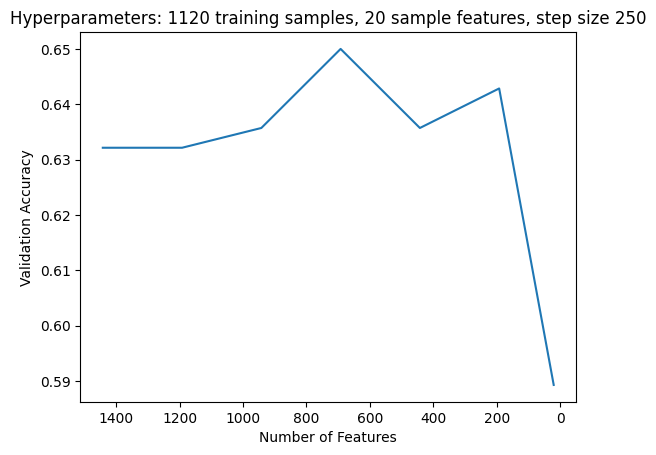

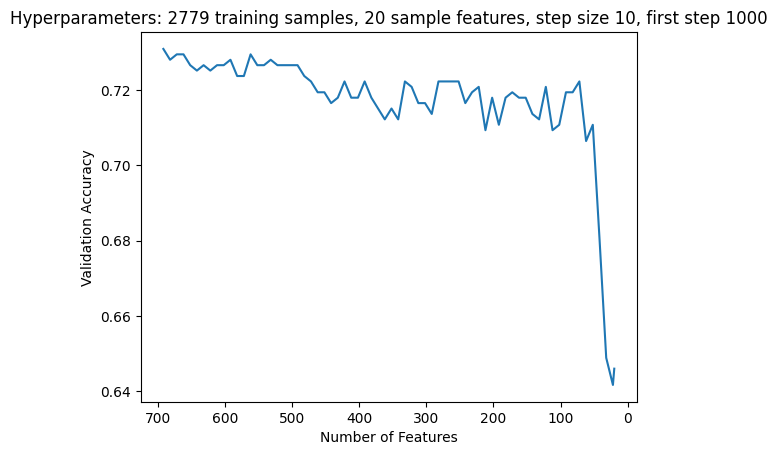

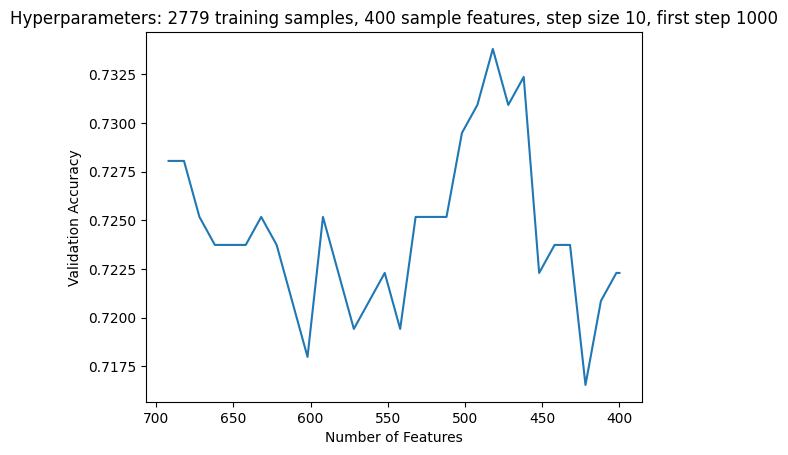

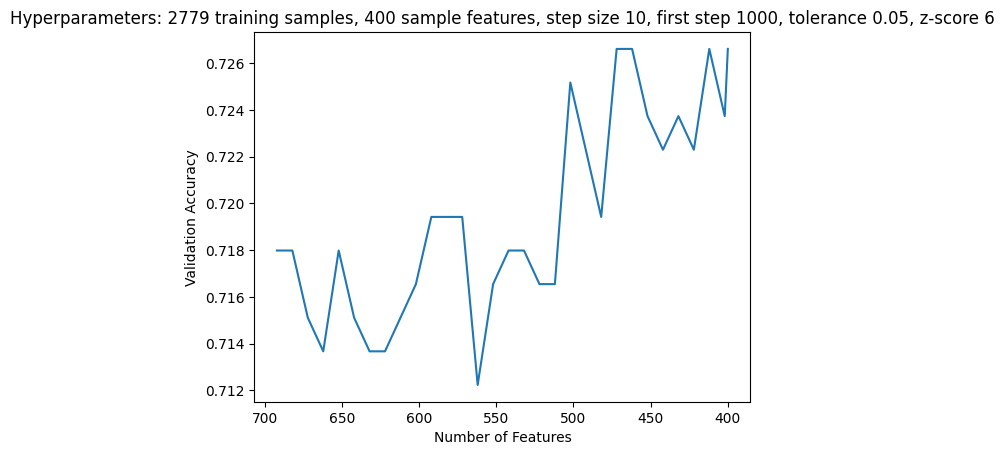

In [14]:
"""Plotting Validation Error"""
# parse data from log, where x = features reduced to, and y = validation accuracy
log_names = ["./logs/1120-20-250.log", "./logs/2779-20-10(1000).log", "./logs/2779-400-10(1000)-tol0.01.log", "./logs/2779-400-10(1000)-tol0.05-z6.log"]
for log_name in log_names:
    plotfile = open(log_name, 'r')
    num_features_plot = []
    accuracies_plot = []

    for line in plotfile:
        line = line.strip()
        elems = line.split()
        if len(elems) == 6: # if "Reducing from" line
            num_features_plot.append(int(elems[4]))
        elif len(elems) == 3: # if "Validation accuracy" line
            accuracies_plot.append(float(elems[2]))
        else: # if first line
            plt.title(line)

    plotfile.close()

    plt.plot(num_features_plot, accuracies_plot)
    plt.xlabel("Number of Features")
    plt.ylabel("Validation Accuracy")
    plt.gca().invert_xaxis()
    plt.show()


Literally Just SVM

In [ ]:
"""Testing SVM parameters"""
print("---Validating Model---")
TOL = 0.1

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(training_samples_scaled, training_labels_encoded, test_size=0.2)
print(f"Hyperparameters: {int(X_train.shape[0])} training samples, tolerance {TOL}")

# Train the model with RBF kernel
model = SVC(kernel="rbf", C=1, decision_function_shape="ovo", gamma="scale", tol=TOL, max_iter=-1)
model.fit(X_train, y_train)

# Predict on the validation set with the reduced feature set
y_pred = model.predict(X_val)
validation_accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {validation_accuracy}")


---Validating Model---
Hyperparameters: 5120 training samples, tolerance 0.1
Validation Accuracy: 0.5700058582308143


In [ ]:
from tensorflow.keras import Sequential
# Figure out what kind of pooling method is best (Max, average, or sum )
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
#smaller filter size, is more accurate but takes more training time and could lead to overfitting
filter_size = 32
filter_shape = (3,3)

